## Black-Scholes equation

The Black-Scholes differential equation for an european option call is defined as:

$$
    \frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0
$$

Where $0 \leq t \leq T$ and $S \geq 0$. The coefficients $r$ and $\sigma$ are positive.

The boundary conditions are:

\begin{cases}
    V(S, t = T) = \max(S - K, 0) \\
    \lim_{S \to 0^ +} V(S, t) = 0 \\
    V(S, t) \approx S - K e^{- r (T - t)} \quad \text{for} \quad S \to + \infty
\end{cases}

With the coefficient $K$ positive as well.

First, let's make these substitutions to simplify the problem:

\begin{cases}
    x = \ln{S} \\
    \tau = T - t \\
    U(x, \tau) = V(S = e^ x, t = T - \tau)
\end{cases}

We are going to rewrite the problem's formulation in terms of $x$ and $\tau$.

In [1]:
# Importing Sympy
import sympy as smp

In [2]:
# BS equation symbols
S, t = smp.symbols("S t", real = True, nonnegative = True)
sigma, r = smp.symbols("\\sigma r", real = True, positive = True, constant = True)
V = smp.Function("V", real = True)(S, t)

# Substitutions symbols
x = smp.symbols("x", real = True)
tau = smp.symbols("\\tau", real = True)
T = smp.symbols("T", real = True, positive = True, constant = True)
U = smp.Function("U", real = True)(x, tau)

In [3]:
# BS equation
equation = smp.Eq(smp.Derivative(V, t, 1) + ((sigma * S) ** 2 * smp.Derivative(V, S, 2)) / 2 + r * S * smp.Derivative(V, S, 1) - r * V, 0)
equation

Eq(S**2*\sigma**2*Derivative(V(S, t), (S, 2))/2 + S*r*Derivative(V(S, t), S) - r*V(S, t) + Derivative(V(S, t), t), 0)

In [4]:
# Substituting the derivatives
dVdS = smp.diff(U.subs([(x, smp.log(S)),
        (tau, T - t)]), S, 1)

dVdt = smp.diff(U.subs([(x, smp.log(S)),
        (tau, T - t)]), t, 1)

d2VdS2 = smp.diff(U.subs([(x, smp.log(S)),
        (tau, T - t)]), S, 2)

In [5]:
# Substituting into BS
equation = smp.simplify(equation.subs([
    (smp.Derivative(V, t, 1), dVdt),
    (smp.Derivative(V, S, 1), dVdS),
    (smp.Derivative(V, S, 2), d2VdS2),
    (S, smp.exp(x)),
    (t, T - tau),
    (V.subs([(S, smp.exp(x)),
             (t, T - tau)]), U)]))

equation

Eq(\sigma**2*(-Derivative(U(x, \tau), x) + Derivative(U(x, \tau), (x, 2)))/2 - r*U(x, \tau) + r*Derivative(U(x, \tau), x) - Derivative(U(x, \tau), \tau), 0)

Then, we got the following differential equation:

$$
    \frac{\partial U}{\partial \tau} = \frac{\sigma^{2}}{2} \frac{\partial^{2} U}{\partial x^{2}} + \left(r - \frac{\sigma^{2}}{2}\right) \frac{\partial U}{\partial x} - r U
$$

This is a convection-diffusion-reaction equation with the the characteristics:

- Diffusion term:  $\frac{\sigma^{2}}{2} \frac{\partial^{2} U}{\partial x^{2}}$ representing the diffusion phenomena with coefficient $D = \frac{\sigma^{2}}{2}$.

- Convection term: $\left(r - \frac{\sigma^{2}}{2}\right) \frac{\partial U}{\partial x}$ representing the convection phenomena with drift velocity $v = r - \frac{\sigma^{2}}{2}$.

- Reaction term: $-r U$ representing a sink or decay reaction with rate $r$.

The boundary conditions are rewritten as:

\begin{cases}
    U(x, 0) = \max(e^ x - K, 0) \\
    \lim_{x \to - \infty} U(x, \tau) = 0 \\
    U(x, \tau) \approx e^ x - K e^ {- r \tau} \quad \text{for} \quad x \to + \infty
\end{cases}

Let's finally solve it.

In [6]:
# Importing libraries
import deepxde as xde
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fast")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [7]:
# Constants
K = 200 # Strike
T = 1 # Time to maturity
sigma = 0.3 # Volatility
r = 0.05 # Risk-free interest rate

# Limits of S (and x)
S_min = 0.1 * K
S_max = 3 * K
x_min = np.log(S_min)
x_max = np.log(S_max)

In [8]:
# Defining a GeometryXTime instance
geom = xde.geometry.Interval(x_min, x_max)
timedomain = xde.geometry.TimeDomain(0, T)
geomtime = xde.geometry.GeometryXTime(geom, timedomain)

In [9]:
# Defining the Black-Scholes residual
def Black_Scholes_differential_equation_residual(xtau, U):
    
    dUdt = xde.grad.jacobian(U, xtau, i = 0, j = 1)
    dUdx = xde.grad.jacobian(U, xtau, i = 0, j = 0)
    d2Udx2 = xde.grad.hessian(U, xtau, i = 0, j = 0)

    return dUdt - sigma ** 2 / 2 * d2Udx2 - (r - sigma ** 2 / 2) * dUdx + r * U # Residual

In [10]:
# Defining the boundary and initial conditions
initial_condition = xde.icbc.IC(
    geom = geomtime,
    func = lambda xtau: np.maximum(np.exp(xtau[:, 0:1]) - K, 0),
    on_initial = lambda _, on_initial: on_initial
)

boundary_condition_lower = xde.icbc.DirichletBC(
    geom = geomtime,
    func = lambda _: 0,
    on_boundary = lambda xtau, on_boundary: on_boundary and xde.utils.isclose(xtau[0], x_min)
)

boundary_condition_upper = xde.icbc.DirichletBC(
    geom = geomtime,
    func = lambda xtau: np.exp(xtau[:, 0:1]) - K * np.exp(- r * xtau[:, 1:2]),
    on_boundary = lambda xtau, on_boundary: on_boundary and xde.utils.isclose(xtau[0], x_max)
)

In [11]:
# Defining the dataset
data = xde.data.TimePDE(geometryxtime = geomtime,
                        pde = Black_Scholes_differential_equation_residual,
                        ic_bcs = [initial_condition, boundary_condition_lower, boundary_condition_upper],
                        num_domain = 2000,
                        num_boundary = 200,
                        num_initial = 100,
                        train_distribution = 'uniform'
                        )

In [12]:
# Defining the network and the model
network = xde.nn.FNN(layer_sizes = [2] + [30] * 3 + [1],
                     activation = "tanh",
                     kernel_initializer = "Glorot normal")

model = xde.Model(data, network)

Compiling model...
'compile' took 7.689309 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.93e-03, 1.34e+04, 1.77e+00, 1.63e+05]    [3.93e-03, 1.34e+04, 1.77e+00, 1.63e+05]    []  
1000      [3.60e+00, 1.09e+04, 1.46e+03, 1.34e+05]    [3.60e+00, 1.09e+04, 1.46e+03, 1.34e+05]    []  
2000      [1.10e+01, 7.48e+03, 1.87e-01, 1.13e+05]    [1.10e+01, 7.48e+03, 1.87e-01, 1.13e+05]    []  
3000      [1.04e+01, 5.60e+03, 1.51e-01, 9.37e+04]    [1.04e+01, 5.60e+03, 1.51e-01, 9.37e+04]    []  
4000      [1.35e+01, 4.13e+03, 2.18e-03, 7.71e+04]    [1.35e+01, 4.13e+03, 2.18e-03, 7.71e+04]    []  
5000      [1.94e+01, 2.98e+03, 2.38e-03, 6.24e+04]    [1.94e+01, 2.98e+03, 2.38e-03, 6.24e+04]    []  
6000      [2.83e+01, 2.09e+03, 1.08e-03, 4.95e+04]    [2.83e+01, 2.09e+03, 1.08e-03, 4.95e+04]    []  
7000      [4.26e+01, 1.41e+03, 3.61e-03, 3.82e+04]    [4.26e+01, 1.41e+03, 3.61e-03, 3.82e+04]    []  
8

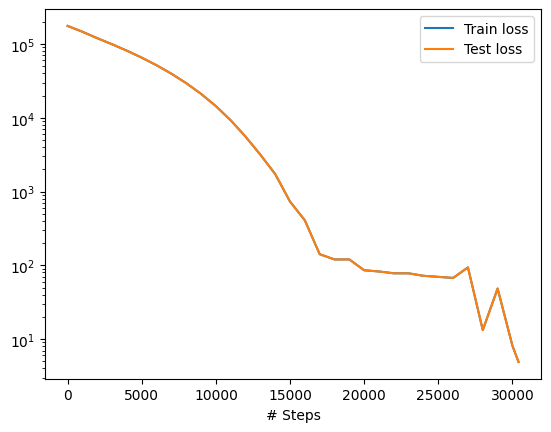

In [13]:
# Training the model
early_stopping = xde.callbacks.EarlyStopping(min_delta = 1e-4, patience = 2000) # Initialize early stopping callback to prevent overfitting during training

# Phase I: Adam optimizer
model.compile("adam", lr = 1e-03)
losshistory, train_state = model.train(iterations = 30_000, callbacks = [early_stopping])

# Phase II: L-BFGS fine-tuning
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Loss history results
xde.utils.plot_loss_history(losshistory)
plt.show()

To enhance the model, let's implement a personalized adaptive training method

In [14]:
# Initialize adaptive training parameters
mean_residual = 1  # Initial value (will be updated in first iteration)
mean_residual_list = []  # Store history of mean residuals across iterations
improvement_patience_mean_residual = 3  # Allowed consecutive iterations without significant improvement
min_improvement_threshold = 0.09  # Minimum required relative improvement (9%)
min_iterations_trigger = 2  # Minimum iterations before checking for improvement
total_max_iterations = 10  # Maximum number of adaptive iterations allowed
iteration_counter = 0  # Counter for current iteration
mean_residual_error_threshold = 0.06  # Target mean residual value
no_improvement_counter_mean_residual = 0  # Counts iterations without significant improvement

# Main adaptive training loop - continues until residual is below threshold or max iterations reached
while mean_residual > mean_residual_error_threshold and iteration_counter < total_max_iterations:
    iteration_counter += 1
    print(f"\n--- Adaptive Iteration {iteration_counter} ---")
    
    # Sample points from different regions of the domain for comprehensive evaluation
    random_points = geomtime.random_points(1000)  # Interior points
    random_boundary_points = geomtime.random_boundary_points(100)  # Boundary points
    random_initial_points = geomtime.random_initial_points(50)  # Initial condition points
    xtau = np.vstack([random_points, random_boundary_points, random_initial_points])  # Combine all points

    # Calculate PDE residuals at sampled points
    PDE_residuals = model.predict(xtau, operator = Black_Scholes_differential_equation_residual)
    errors = np.absolute(PDE_residuals)  # Absolute values of residuals
    mean_residual = np.mean(errors)  # Calculate mean residual
    mean_residual_list.append(mean_residual)  # Store for tracking progress
    print(f"Mean residual: {mean_residual:.3e}")  # Print in scientific notation
    
    # Check for significant improvement after minimum required iterations
    if len(mean_residual_list) >= min_iterations_trigger:
        
        # Calculate relative improvement compared to previous iteration
        relative_improvement = (mean_residual_list[-2] - mean_residual) / mean_residual_list[-2]
        print(f"Relative improvement: {relative_improvement * 100:.2f}%")
        
        # Check if improvement meets the threshold
        if relative_improvement < min_improvement_threshold:
            no_improvement_counter_mean_residual += 1
            print(f"No significant improvement for {no_improvement_counter_mean_residual} iteration(s)")
            
            # Stop training if no improvement for consecutive iterations exceeding patience
            if no_improvement_counter_mean_residual >= improvement_patience_mean_residual:
                print("Training stopped due to lack of significant improvement")
                break
        else:
            no_improvement_counter_mean_residual = 0  # Reset counter if improvement is significant
    
    # Identify points with highest errors for refinement (active learning)
    xt_indices = np.argsort((- errors).reshape(1, - 1))[0][0:200]  # Get indices of top 200 worst points
    new_data = xtau[xt_indices]  # Extract the problematic points
    
    print("Adding 200 new points")
    data.add_anchors(new_data)  # Add these points to training data

    # First training phase: Use Adam optimizer for global exploration
    model.compile("adam", lr = 1e-4)
    model.train(iterations = 10_000, disregard_previous_best = True, callbacks = [early_stopping])
    
    # Second training phase: Use L-BFGS for fine-tuning and local convergence
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

# Final status message based on termination reason
if mean_residual < mean_residual_error_threshold:
    print(f"\nSuccess: Mean residual error {mean_residual:.3e} is below threshold {mean_residual_error_threshold}")
elif iteration_counter >= total_max_iterations:
    print(f"\nStopped: Reached maximum iterations ({total_max_iterations})")
else:
    print(f"\nStopped: No significant improvement after {improvement_patience_mean_residual} iterations")

print(f"Final mean residual error: {mean_residual:.3e}")


--- Adaptive Iteration 1 ---
Mean residual: 2.158e+01
Adding 200 new points
Compiling model...
'compile' took 0.001006 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
30411     [5.19e+04, 2.65e+00, 6.18e-03, 5.02e-01]    [1.75e+00, 2.65e+00, 6.18e-03, 5.02e-01]    []  
31000     [4.24e+03, 3.03e+02, 1.85e+00, 5.19e+00]    [1.52e+03, 3.03e+02, 1.85e+00, 5.19e+00]    []  
32000     [7.60e+02, 3.69e+02, 3.17e-01, 3.93e+01]    [4.03e+02, 3.69e+02, 3.17e-01, 3.93e+01]    []  
33000     [3.92e+02, 3.75e+02, 8.75e-02, 4.79e+01]    [2.45e+02, 3.75e+02, 8.75e-02, 4.79e+01]    []  
34000     [2.54e+02, 3.61e+02, 4.41e-02, 4.56e+01]    [1.60e+02, 3.61e+02, 4.41e-02, 4.56e+01]    []  
35000     [1.76e+02, 3.31e+02, 3.06e-02, 3.98e+01]    [1.10e+02, 3.31e+02, 3.06e-02, 3.98e+01]    []  
36000     [1.22e+02, 2.93e+02, 2.98e-02, 4.06e+01]    [7.60e+01, 2.93e+02, 2.98e-02, 4.06e+01]    []  
37000     [8.56e+01, 2.46e+

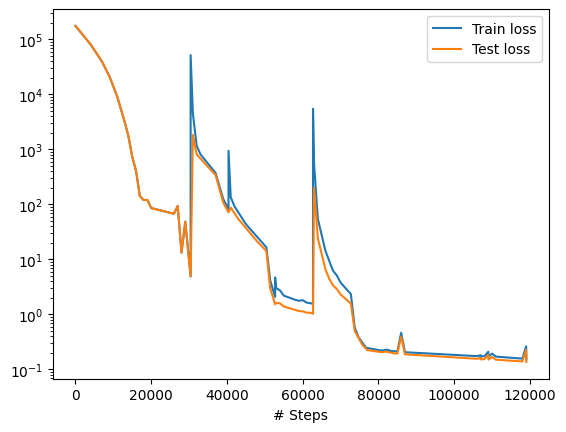

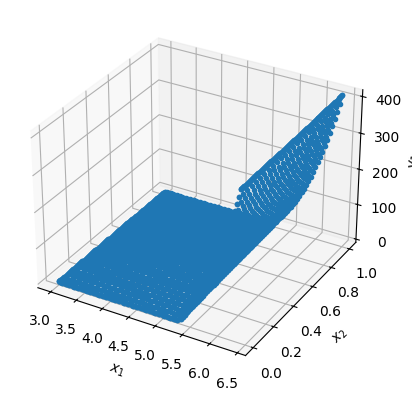

In [15]:
# Visualizing training history to analyze convergence behavior
xde.utils.plot_loss_history(losshistory)
plt.show()
xde.utils.plot_best_state(train_state)
plt.show()

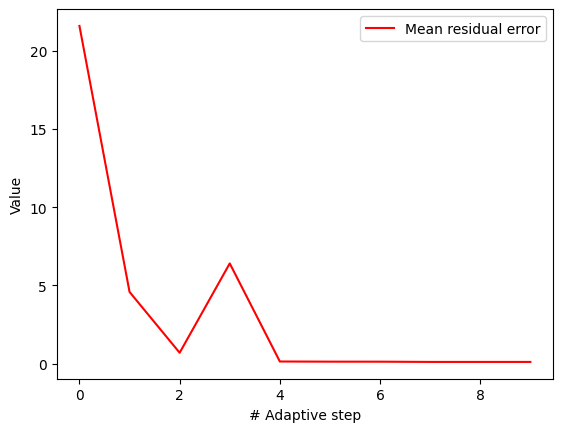

In [16]:
# Plotting the mean residual error progress
plt.plot(mean_residual_list, color = "red", label = "Mean residual error")
plt.xlabel("# Adaptive step")
plt.ylabel("Value")
plt.legend()
plt.show()

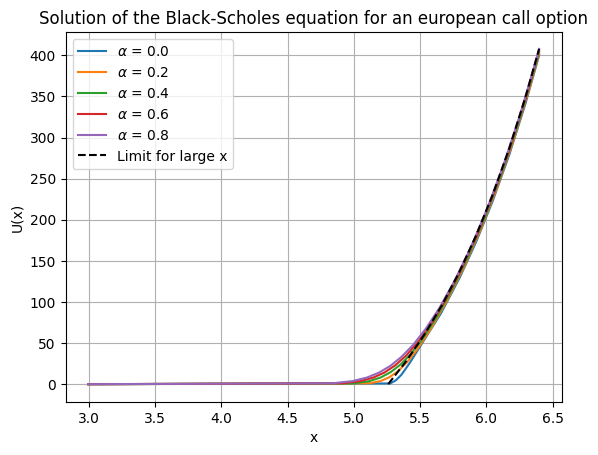

In [17]:
# Importing masked_less from numpy
from numpy.ma import masked_less

# Making predictions and plotting results
x = np.linspace(x_min, x_max, 2000)

for alpha in np.arange(0, T, 0.2): # Some values of tau
    tau = np.ones(len(x)) * alpha
    matrix = np.column_stack((x, tau))
    U = model.predict(matrix).flatten() # Computing U (x, tau)

    # Plotting U(x, tau)
    plt.plot(x, U, label = f"$\\alpha$ = {round(alpha, 2)}")

# Limit for x large
superior_limit = np.exp(x) - K * np.exp(- r * tau)
superior_limit = masked_less(superior_limit, 0, copy = True)

plt.plot(x, superior_limit, label = "Limit for large x", color = 'black', linestyle = '--')
plt.title("Solution of the Black-Scholes equation for an european call option")
plt.xlabel("x")
plt.ylabel("U(x)")
plt.legend()
plt.grid()
plt.show()